## Klasyfikacja chorób oka na podstawie obrazów dna oka

Badany zbiór danych zawiera 16242 zdjęć dna oka. Zbiór danych dostępny jest pod linkiem https://data.mendeley.com/datasets/s9bfhswzjb/1. Autorzy udostępniają zbiór oryginalny oraz poddany augmentacji. W tym notatniku wykorzystywany był zbiór rozszerzony. Zbiór zawiera zdjęcia należące do następujących klas:
- Odwarstwienie siatkówki (Retinal Detachment)
- Jaskra (Glaucoma)
- Retinopatia cukrzycowa (Diabetic Retinopathy)
- Centralna chorioretinopatia surowicza (Central serous chorioretinopathy)
- Skrzydlik (Pterygium)
- Krótkowzroczność (Myopia)
- Bliznowacenie ciałka żółtego (Macular Scar)
- Retinopatia barwnikowa (Retinitis Pigmentosa)
- Obrzęk tarczy nerwu wzrokoweg (Disc Edema)
- Zdrowe oko (Healthy)
Zdjęcia są już podzielona na katalogi odpowiadające odpowienim klasą. Choroby są trudne do odróżnienia dla laika i ich klasyfikacja może stanowić ciekawy problem dla modeli uczenia maszynowego.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
from tqdm import tqdm


## Wczytanie i wizualizacja danych

In [2]:
dataset_path = 'data'

In [3]:
IMG_SIZE = (128, 128)

In [4]:
categories = os.listdir(dataset_path)
X = []
y = []
for label, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)

    if not os.path.isdir(category_path):
        continue

    for img_name in tqdm(os.listdir(category_path), desc=f"Przetwarzanie {category}"):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, IMG_SIZE)
        img_flattened = img.flatten()

        X.append(img_flattened)
        y.append(label)


Przetwarzanie Diabetic Retinopathy: 100%|██████████| 3444/3444 [00:16<00:00, 206.33it/s]
Przetwarzanie Central Serous Chorioretinopathy [Color Fundus]: 100%|██████████| 606/606 [00:03<00:00, 169.23it/s]
Przetwarzanie Healthy: 100%|██████████| 2676/2676 [00:15<00:00, 172.03it/s]


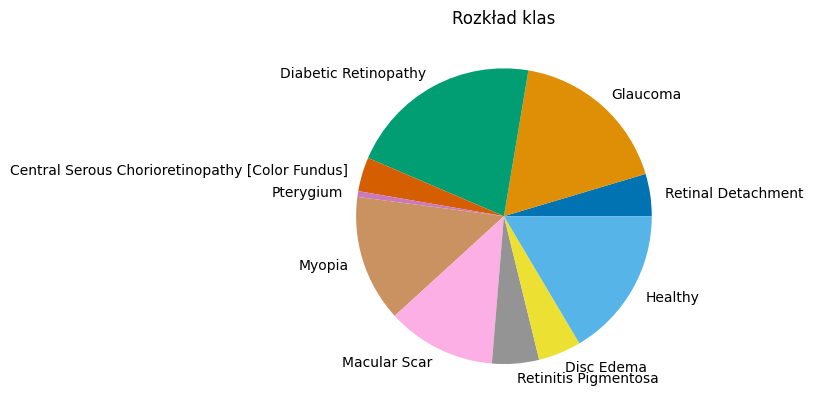

In [10]:
palette_color = sns.color_palette('colorblind')
unique_values, counts = np.unique(y, return_counts=True)
plt.pie(counts, labels=categories, colors=palette_color)
plt.title('Rozkład klas')
plt.show()

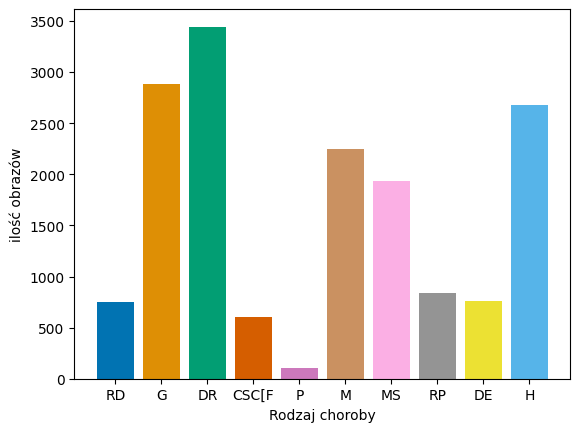

In [18]:
plt.bar(categories_short, counts, color=palette_color)
plt.xlabel('Rodzaj choroby')
plt.ylabel('ilość obrazów')
plt.show()

In [5]:
X = np.array(X)
y = np.array(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost

In [7]:
xgb_classifier = XGBClassifier(objective='multi:softprob')
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)

In [9]:
accuracy = accuracy_score(y_test, y_pred_xgb, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_xgb, normalize = False)
precision = precision_score(y_test, y_pred_xgb, average = 'weighted')
recall = recall_score(y_test, y_pred_xgb, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.5903354878424131
Accuracy count: 1918.0
Precision: 0.5971187903622562
Recall: 0.5903354878424131


## SVM

In [ ]:
svm_classifier = SVC(kernel='rbf', probability=True)
svm_classifier.fit(X_train, y_train)


In [12]:
y_pred_svm = svm_classifier.predict(X_test)

In [13]:
accuracy = accuracy_score(y_test, y_pred_svm, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_svm, normalize = False)
precision = precision_score(y_test, y_pred_svm, average = 'weighted')
recall = recall_score(y_test, y_pred_svm, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.4155124653739612
Accuracy count: 1350.0
Precision: 0.3662451235587665
Recall: 0.4155124653739612


/home/michal/EyeDiseaseClassification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Random Forest

### Hiperparametryzacja

In [12]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 3)]
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
class_weight = ['balanced', 'balanced_subsample', None]

param_grid = {'n_estimators': n_estimators,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}

In [8]:
rf_classifier = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    estimator = rf_classifier,
    param_distributions = param_grid,
    n_iter = 10,
    cv = 3,
    verbose=0,
    random_state=42,
)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 60, 110, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 600, 1000]},
                   random_state=42)

In [9]:
rf_classifier = rf_random.best_estimator_

In [10]:
y_pred_rf = rf_classifier.predict(X_test)

### Ocena działania modelu

In [11]:
accuracy = accuracy_score(y_test, y_pred_rf, normalize = True)
accuracy_count = accuracy_score(y_test, y_pred_rf, normalize = False)
precision = precision_score(y_test, y_pred_rf, average = 'weighted')
recall = recall_score(y_test, y_pred_rf, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.5986457371498922
Accuracy count: 1945.0
Precision: 0.6046904601649707
Recall: 0.5986457371498922


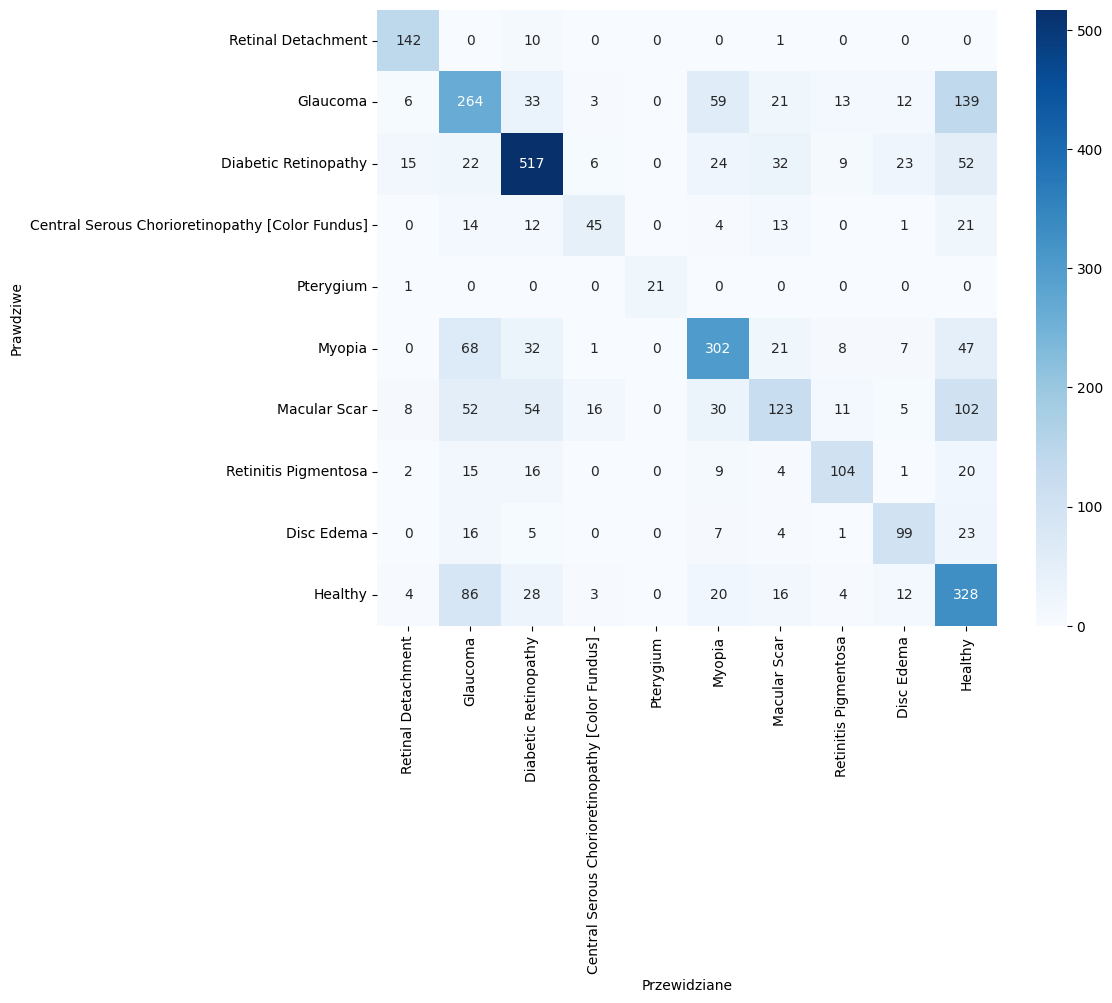

In [12]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel("Przewidziane")
plt.ylabel("Prawdziwe")
plt.show()

In [13]:
print(classification_report(y_test, y_pred_rf, target_names=categories))

                                                 precision    recall  f1-score   support

                             Retinal Detachment       0.80      0.93      0.86       153
                                       Glaucoma       0.49      0.48      0.49       550
                           Diabetic Retinopathy       0.73      0.74      0.73       700
Central Serous Chorioretinopathy [Color Fundus]       0.61      0.41      0.49       110
                                      Pterygium       1.00      0.95      0.98        22
                                         Myopia       0.66      0.62      0.64       486
                                   Macular Scar       0.52      0.31      0.39       401
                           Retinitis Pigmentosa       0.69      0.61      0.65       171
                                     Disc Edema       0.62      0.64      0.63       155
                                        Healthy       0.45      0.65      0.53       501

                   

In [14]:
# Zapis modelu do pliku
with open("model_best2.pkl", "wb") as f:
    pickle.dump(rf_classifier, f)

## Poprawa wyników

Ponieważ testowane modele osiągają kiepskie wyniki spróbujemy zastosować inne metody które mogą pomóc w klasyfikacji.

### Histogram of Oriented Gradients (HOG)

In [6]:
from skimage.feature import hog

In [7]:
X_hog = []
for img in X:
    img_reshaped = img.reshape(IMG_SIZE)
    hog_features = hog(img_reshaped, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    X_hog.append(hog_features)

X_hog = np.array(X_hog)

In [8]:
X_hog_train, X_hog_test, y_hog_train, y_hog_test = train_test_split(X_hog, y, test_size=0.2, random_state=42)

In [9]:
rf_hog_classifier = RandomForestClassifier()
rf_hog_classifier.fit(X_hog_train, y_hog_train)
y_pred_rf = rf_hog_classifier.predict(X_hog_test)

In [10]:
accuracy = accuracy_score(y_hog_test, y_pred_rf, normalize = True)
accuracy_count = accuracy_score(y_hog_test, y_pred_rf, normalize = False)
precision = precision_score(y_hog_test, y_pred_rf, average = 'weighted')
recall = recall_score(y_hog_test, y_pred_rf, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.42197599261311175
Accuracy count: 1371.0
Precision: 0.39649156234558863
Recall: 0.42197599261311175


Wyniki są nawet gorsze niż poprzednio, ale spróbujmy wykorzystać hiperparametryzację

In [13]:
rf_classifier = RandomForestClassifier()
rf_random = RandomizedSearchCV(
    estimator = rf_classifier,
    param_distributions = param_grid,
    n_iter = 10,
    cv = 3,
    verbose=0,
    random_state=42,
)
rf_random.fit(X_hog_train, y_hog_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 60, 110, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 600, 1000]},
                   random_state=42)

In [15]:
rf_classifier = rf_random.best_estimator_
y_pred_rf = rf_classifier.predict(X_hog_test)

In [17]:
accuracy = accuracy_score(y_hog_test, y_pred_rf, normalize = True)
accuracy_count = accuracy_score(y_hog_test, y_pred_rf, normalize = False)
precision = precision_score(y_hog_test, y_pred_rf, average = 'weighted')
recall = recall_score(y_hog_test, y_pred_rf, average = 'weighted')

print(f"Accuracy: {accuracy}")
print(f"Accuracy count: {accuracy_count}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.4619883040935672
Accuracy count: 1501.0
Precision: 0.4420346497638141
Recall: 0.4619883040935672


## Wnioski
Niestety, zastosowane, klasyczne modele uczenia maszynowego nie osiągnęły zadowalających rezultatów. W szczególności zastosowanie metody HOG okazało się nietrafionym pomysłem. W związku z tym w pliku dl_classification wykorzystane zostały splotowe sieci neuronowe.